# Investigating the word embedding model

In [ ]:
import random
from collections import defaultdict, Counter    
import gensim
from gensim.models import KeyedVectors
import gensim.downloader
import sys
import time
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Run the helper function down

In [ ]:
Xtrain, Ytrain = read_data('/content/drive/MyDrive/NLP course/Assignment 4/data/train.tsv')
Xval, Yval = read_data('/content/drive/MyDrive/NLP course/Assignment 4/data/devel.tsv')

In [ ]:
#Xtrain[100]

In [ ]:
# import torch
# from torch import nn

# class BaselineSequenceModel(nn.Module):
    
#     def __init__(self, seq_labeler):
#         super().__init__()                
        
#         # Here is how you access the NERParameters.
#         p = seq_labeler.params
        
#         # The model consists of just a word embedding layer and a
#         # linear output unit. We use the vocabulary to create the embedding layer.        
#         self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
#                                                                         emb_dim=p.word_emb_dim)
        
#         # The dimensionality of the word embedding model.
#         word_emb_dim = self.word_embedding.weight.shape[1]
        
#         # Output unit.
#         self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
#     def forward(self, words):
#         # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)
                
#         # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
#         word_repr = self.word_embedding(words)
            
#         # We predict the BIO label simply by applying a linear model to
#         # the word embedding at that position.
        
#         # The shape of the output is (batch_size, max_sen_length, n_labels),
#         # where n_labels is the size of the output label vocabulary.
#         return self.top_layer(word_repr)

In [ ]:
import torch
from torch import nn

class BaselineSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        p = seq_labeler.params
             
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        
        self.LSTM = nn.LSTM(input_size=p.word_emb_dim, 
                            hidden_size=64, 
                            num_layers=1, 
                            batch_first=True, 
                            bidirectional=True)
        
        word_emb_dim = self.word_embedding.weight.shape[1]
        
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
        
        self.relu = nn.ReLU()
                        
    def forward(self, words):
        h0 = torch.zeros(self.LSTM.num_layers+1, words.size(0), self.LSTM.hidden_size).cuda()
        c0 = torch.zeros(self.LSTM.num_layers+1, words.size(0), self.LSTM.hidden_size).cuda()
        
        x = self.word_embedding(words)
        x, (hh, cn) = self.LSTM(x, (h0, c0))
        x = self.top_layer(x)
        return x

**Case 1-Random Embedding, 	Fine_tuning=No**

with Random Embedding, 	Fine_tuning=No
Run= 1
We are not using the pretrained model
Epoch 1: train loss = 0.4167, val f1: 0.3641, time = 3.3327
Epoch 6: train loss = 0.0194, val f1: 0.6303, time = 3.0278
Epoch 11: train loss = 0.0013, val f1: 0.6573, time = 2.9918
Epoch 16: train loss = 0.0005, val f1: 0.6528, time = 3.0502

Final evaluation on the validation set:
Best result on the validation set (epoch 11):
Overall: P = 0.7039, R = 0.6169, F1 = 0.6576
Chemical: P = 0.7691, R = 0.6366, F1 = 0.6966
Disease: P = 0.6315, R = 0.5921, F1 = 0.6112
--------------------------------------------
Run= 2
We are not using the pretrained model
Epoch 1: train loss = 0.4166, val f1: 0.2981, time = 3.0546
Epoch 6: train loss = 0.0211, val f1: 0.6067, time = 3.0732
Epoch 11: train loss = 0.0015, val f1: 0.5926, time = 2.9998
Epoch 16: train loss = 0.0005, val f1: 0.5947, time = 3.0244

Final evaluation on the validation set:
Best result on the validation set (epoch 5):
Overall: P = 0.5742, R = 0.6432, 

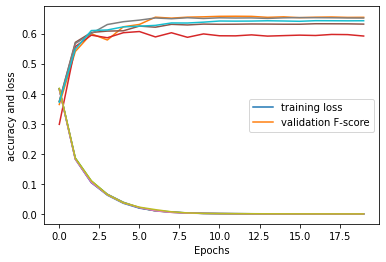

In [ ]:
 class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1  
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False
print('with Random Embedding, 	Fine_tuning=No')
f1=[]
for i in range(0,5):
  print('Run=',i+1)
  nerObj=NERParameters()
  nerObj.random_seed=i

  ner_system = SequenceLabeler(nerObj, BaselineSequenceModel)
  F1_best=ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  f1.append(F1_best)
  print('--------------------------------------------')
print(f1)
print('The best F1 score over ',i+1,' is',(sum(f1)/len(f1)))


**Case 2-with Random Embedding, 	Fine_tuning=Yes**

We are using the fine tuning model
with Random Embedding, 	Fine_tuning=yes
Run= 1
We are not using the pretrained model
Epoch 1: train loss = 0.3725, val f1: 0.5186, time = 3.4239
Epoch 6: train loss = 0.0046, val f1: 0.6924, time = 3.2954
Epoch 11: train loss = 0.0003, val f1: 0.6971, time = 3.2845
Epoch 16: train loss = 0.0001, val f1: 0.6972, time = 3.2990

Final evaluation on the validation set:
Best result on the validation set (epoch 15):
Overall: P = 0.7945, R = 0.6212, F1 = 0.6972
Chemical: P = 0.8858, R = 0.6078, F1 = 0.7209
Disease: P = 0.7071, R = 0.6380, F1 = 0.6708
--------------------------------------------
Run= 2
We are not using the pretrained model
Epoch 1: train loss = 0.3718, val f1: 0.5170, time = 3.3096
Epoch 6: train loss = 0.0048, val f1: 0.6547, time = 3.3261
Epoch 11: train loss = 0.0003, val f1: 0.6492, time = 3.2919
Epoch 16: train loss = 0.0001, val f1: 0.6504, time = 3.2787

Final evaluation on the validation set:
Best result on the validation set (epoch 8

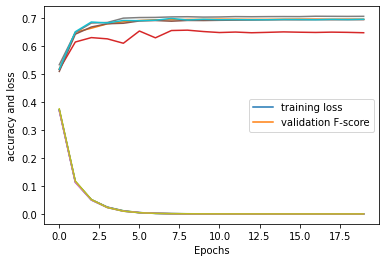

In [ ]:
 class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1  
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = True
    if finetune_word_emb:
      print('We are using the fine tuning model')
    else:
      print('We are not using the fine tuning model')


    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False
print('with Random Embedding, 	Fine_tuning=yes')
f1=[]
for i in range(0,5):
  print('Run=',i+1)
  nerObj=NERParameters()
  nerObj.random_seed=i

  ner_system = SequenceLabeler(nerObj, BaselineSequenceModel)
  F1_best=ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  f1.append(F1_best)
  print('--------------------------------------------')
print(f1)
print('The best F1 score over ',i+1,' is',(sum(f1)/len(f1)))


**Case 3-Gensim (Inbuilt)=glove-wiki-gigaword-100, Fine tuning=No**

In [ ]:
def load_gensim_vectors(model_file, builtin=True, limit=None):
    
    using_new_gensim = gensim.__version__[0] == '4'

    print(f"Loading model '{model_file}' via gensim...", end='')
    sys.stdout.flush()
    if builtin:
        gensim_model = gensim.downloader.load(model_file)
    else:
        gensim_model = KeyedVectors.load_word2vec_format(model_file, binary=True, limit=limit)
    if not limit:
        if using_new_gensim:
            limit = len(gensim_model.index_to_key)
        else:
            limit = len(gensim_model.index2word)
    vectors = torch.FloatTensor(gensim_model.vectors[:limit])
    
    if using_new_gensim:
        voc = gensim_model.index_to_key[:limit]
    else:
        voc = gensim_model.index2word[:limit]
    
    is_cased = False
    for w in voc:
        w0 = w[0]
        if w0.isupper():
            is_cased = True
            break
    
    print(' done!')
    return vectors, voc, is_cased

#model_file='/content/drive/MyDrive/NLP course/Assignment 4/PubMed-and-PMC-w2v-200000.bin'
model_file='glove-wiki-gigaword-100'
gen_model=load_gensim_vectors(model_file, builtin=True)

Loading model 'glove-wiki-gigaword-100' via gensim... done!


We are not using the fine tuning model
with Genism Embedding (Inbuilt)=glove-wiki-gigaword-100, 	Fine_tuning=No
Run= 1
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.5810, val f1: 0.5977, time = 0.6701
Epoch 6: train loss = 0.1912, val f1: 0.6561, time = 0.6619
Epoch 11: train loss = 0.1813, val f1: 0.6622, time = 0.6666
Epoch 16: train loss = 0.1775, val f1: 0.6694, time = 0.6529

Final evaluation on the validation set:
Best result on the validation set (epoch 17):
Overall: P = 0.6515, R = 0.6900, F1 = 0.6702
Chemical: P = 0.7867, R = 0.7862, F1 = 0.7865
Disease: P = 0.5015, R = 0.5688, F1 = 0.5330
--------------------------------------------
Run= 2
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.5601, val f1: 0.5981, time = 0.6701
Epoch 6: train loss = 0.1905, val f1: 0.6513, time = 0.6601
Epoch 11: train loss = 0.1813, val f1: 0.6556, time = 0.6752
Epoch 16: train loss = 0.1780, val f1: 0.6585, time = 0.6635

Final evaluation on t

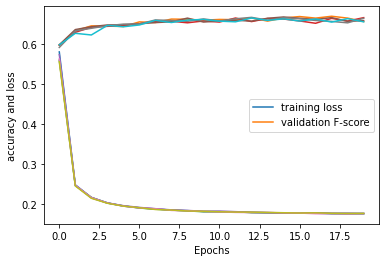

In [ ]:
 class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1  
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False
    if finetune_word_emb:
      print('We are using the fine tuning model')
    else:
      print('We are not using the fine tuning model')


    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False
print('with Genism Embedding (Inbuilt)=glove-wiki-gigaword-100, 	Fine_tuning=No')
f1=[]
for i in range(0,5):
  print('Run=',i+1)
  nerObj=NERParameters()
  nerObj.random_seed=i

  ner_system = SequenceLabeler(nerObj, BaselineSequenceModel)
  F1_best=ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  f1.append(F1_best)
  print('--------------------------------------------')
print(f1)
print('The best F1 score over ',i+1,' is',(sum(f1)/len(f1)))


**Case 4-Gensim (Inbuilt)=glove-wiki-gigaword-100, Fine tuning=Yes**

We are using the fine tuning model
with Genism Embedding (Inbuilt)=glove-wiki-gigaword-100, 	Fine_tuning=yes
Run= 1
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.3992, val f1: 0.6599, time = 4.0167
Epoch 6: train loss = 0.1190, val f1: 0.6779, time = 3.9521
Epoch 11: train loss = 0.1155, val f1: 0.6630, time = 3.9658
Epoch 16: train loss = 0.1140, val f1: 0.6696, time = 3.9598

Final evaluation on the validation set:
Best result on the validation set (epoch 5):
Overall: P = 0.6386, R = 0.7222, F1 = 0.6779
Chemical: P = 0.7587, R = 0.8120, F1 = 0.7845
Disease: P = 0.5046, R = 0.6090, F1 = 0.5519
--------------------------------------------
Run= 2
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.3823, val f1: 0.6557, time = 3.9274
Epoch 6: train loss = 0.1177, val f1: 0.6588, time = 3.9361
Epoch 11: train loss = 0.1153, val f1: 0.6585, time = 3.9282
Epoch 16: train loss = 0.1139, val f1: 0.6549, time = 3.9325

Final evaluation on the v

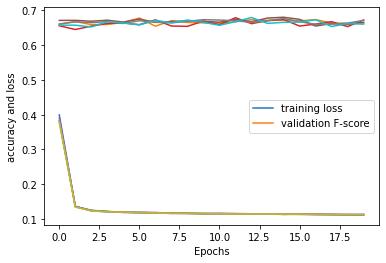

In [ ]:
 class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1  
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = True
    if finetune_word_emb:
      print('We are using the fine tuning model')
    else:
      print('We are not using the fine tuning model')


    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False
print('with Genism Embedding (Inbuilt)=glove-wiki-gigaword-100, 	Fine_tuning=yes')
f1=[]
for i in range(0,5):
  print('Run=',i+1)
  nerObj=NERParameters()
  nerObj.random_seed=i

  ner_system = SequenceLabeler(nerObj, BaselineSequenceModel)
  F1_best=ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  f1.append(F1_best)
  print('--------------------------------------------')
print(f1)
print('The best F1 score over ',i+1,' is',(sum(f1)/len(f1)))


**Case 5-Gensim Domain specific word embedding model, Fine tuning=No**

Loading model '/content/drive/MyDrive/NLP course/Assignment 4/PubMed-and-PMC-w2v-200000.bin' via gensim... done!
We are not using the fine tuning model
Run= 1
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.5810, val f1: 0.5977, time = 0.6660
Epoch 6: train loss = 0.1912, val f1: 0.6561, time = 0.6357
Epoch 11: train loss = 0.1813, val f1: 0.6622, time = 0.6451
Epoch 16: train loss = 0.1775, val f1: 0.6694, time = 0.6468

Final evaluation on the validation set:
Best result on the validation set (epoch 17):
Overall: P = 0.6515, R = 0.6900, F1 = 0.6702
Chemical: P = 0.7867, R = 0.7862, F1 = 0.7865
Disease: P = 0.5015, R = 0.5688, F1 = 0.5330
--------------------------------------------
Run= 2
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.5601, val f1: 0.5981, time = 0.6404
Epoch 6: train loss = 0.1905, val f1: 0.6513, time = 0.6707
Epoch 11: train loss = 0.1813, val f1: 0.6556, time = 0.6610
Epoch 16: train loss = 0.1780, val f1: 0.65

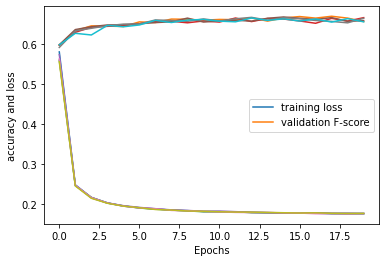

In [ ]:
def load_gensim_vectors(model_file, builtin=False, limit=None):
    ########
    
    #model_file='/content/drive/MyDrive/NLP course/Assignment 4/PubMed-and-PMC-w2v-200000.bin'
    using_new_gensim = gensim.__version__[0] == '4'

    print(f"Loading model '{model_file}' via gensim...", end='')
    sys.stdout.flush()
    if builtin:
        gensim_model = gensim.downloader.load(model_file)
    else:
        gensim_model = KeyedVectors.load_word2vec_format(model_file, binary=True, limit=limit)
    if not limit:
        if using_new_gensim:
            limit = len(gensim_model.index_to_key)
        else:
            limit = len(gensim_model.index2word)
    vectors = torch.FloatTensor(gensim_model.vectors[:limit])
    
    if using_new_gensim:
        voc = gensim_model.index_to_key[:limit]
    else:
        voc = gensim_model.index2word[:limit]
    
    is_cased = False
    for w in voc:
        w0 = w[0]
        if w0.isupper():
            is_cased = True
            break
    
    print(' done!')
    return vectors, voc, is_cased

model_file='/content/drive/MyDrive/NLP course/Assignment 4/PubMed-and-PMC-w2v-200000.bin'
#model_file='glove-wiki-gigaword-100'
gen_model=load_gensim_vectors(model_file, builtin=False)


class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1  
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False
    if finetune_word_emb:
      print('We are using the fine tuning model')
    else:
      print('We are not using the fine tuning model')


    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False
#print('with Genism Domain specific word embedding model=PubMed-and-PMC, 	Fine_tuning=No')
f1=[]
for i in range(0,5):
  print('Run=',i+1)
  nerObj=NERParameters()
  nerObj.random_seed=i

  ner_system = SequenceLabeler(nerObj, BaselineSequenceModel)
  F1_best=ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  f1.append(F1_best)
  print('--------------------------------------------')
print(f1)
print('The best F1 score over ',i+1,' is',(sum(f1)/len(f1)))


**Case 6-Gensim Domain specific word embedding model, Fine tuning=yes**

We are using the fine tuning model
Run= 1
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.3992, val f1: 0.6599, time = 3.9466
Epoch 6: train loss = 0.1190, val f1: 0.6779, time = 3.8942
Epoch 11: train loss = 0.1155, val f1: 0.6630, time = 3.9083
Epoch 16: train loss = 0.1140, val f1: 0.6696, time = 3.9037

Final evaluation on the validation set:
Best result on the validation set (epoch 5):
Overall: P = 0.6386, R = 0.7222, F1 = 0.6779
Chemical: P = 0.7587, R = 0.8120, F1 = 0.7845
Disease: P = 0.5046, R = 0.6090, F1 = 0.5519
--------------------------------------------
Run= 2
Using the pretrained_word_emb model= genism model
Epoch 1: train loss = 0.3823, val f1: 0.6557, time = 3.9196
Epoch 6: train loss = 0.1177, val f1: 0.6588, time = 3.9061
Epoch 11: train loss = 0.1153, val f1: 0.6585, time = 3.9188
Epoch 16: train loss = 0.1139, val f1: 0.6549, time = 3.9100

Final evaluation on the validation set:
Best result on the validation set (epoch 11):
Overall: P = 

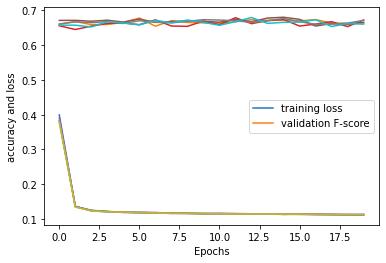

In [ ]:

class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 1  
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = True
    if finetune_word_emb:
      print('We are using the fine tuning model')
    else:
      print('We are not using the fine tuning model')


    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False
#print('with Genism Domain specific word embedding model=PubMed-and-PMC, 	Fine_tuning=No')
f1=[]
for i in range(0,5):
  print('Run=',i+1)
  nerObj=NERParameters()
  nerObj.random_seed=i

  ner_system = SequenceLabeler(nerObj, BaselineSequenceModel)
  F1_best=ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  f1.append(F1_best)
  print('--------------------------------------------')
print(f1)
print('The best F1 score over ',i+1,' is',(sum(f1)/len(f1)))


**Obervation**

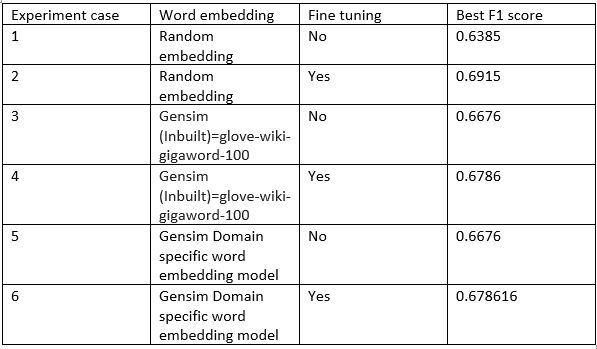

In this task, we need to investigate the effect of the word embedding model on the quality of the entity recognizer. For this we have used the RNN baseline model which have been designed in the previous task as well as the pretrained model that can be downloaded from the genism library. Further we will also experiment the model’s F1 score with and without the fine tuning the model. For each of the model case, the tagger has been ran for the 5 times with different random seed values. For each of the run with certain random seed, the best F1 score has been obtained and the mean best F1 score will be calculated for the model with and without fine tuning. Further more, here are using the 2 pre-trained model from the genism  a pre-trained word embedding called 'glove-wiki-gigaword-100 and another, a domain-specific word embedding trained on a large collection of scientific articles called 'PubMed-and-PMC-w2v-500000' . For the six cases, the model’s best F1 scores are mentioned in the table below.


**Fine tuning** 

It is explicit from the above table that whenever, we use the fine tuning method (switching to True for the fine tuning), the F1 score of the model is increased in all the cases of the pre-trained network.  This is because, fine tuning enable the network to change the weights of the pre-trained model so that while training with our data set, the model’s gradients has been updated and performs well during the validation part.


**Genism- 'glove-wiki-gigaword-100**
For the case 3 and 4, we are using the inbuilt Gensim pre-trained word embedding model ‘glove-wiki-gigaword-100'. We performed the experiment for the 2 case with and without fine tuning the model. Without fine tuning the model, the best F1 obtained is 0.5377. But when the fine tuning of the model is enabled, the F1 score is increased to 0.6015. 

**Genism domain specific model**
In the case 5 and 6, we have used 'PubMed-and-PMC-w2v-500000’ which is the domain specific model for the word embedding model. In this model, the F1 score are almost same as when comparing with the last genism model and also the higher when comparing with the baseline RNN model because this model  is trained on more related scientific data sets . Further like before, we got higher F1 score for the fine-tuned model which allows for the updating the gradient while training the model.


**Helper Functions**

In [ ]:

def read_data(corpus_file):
    with open(corpus_file, encoding='utf-8') as f:
        X = []
        Y = []
        words = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                X.append(words)
                Y.append(labels)
                words = []
                labels = []
            else:
                columns = line.split()
                words.append(columns[0])
                labels.append(columns[-1])
        return X, Y
    

PAD = '___PAD___'
UNKNOWN = '___UNKNOWN___'
BOS = '___BOS___'
EOS = '___EOS___'

class Vocabulary:
    """Manages the numerical encoding of the vocabulary."""
    
    def __init__(self, max_voc_size=None, include_unknown=True, lower=False,
                 character=False, gensim_model=None):

        self.include_unknown = include_unknown
        self.dummies = [PAD, UNKNOWN, BOS, EOS] if self.include_unknown else [PAD, BOS, EOS]
        
        self.character = character
        
        if not gensim_model:
            # String-to-integer mapping
            self.stoi = None
            # Integer-to-string mapping
            self.itos = None
            # Maximally allowed vocabulary size.
            self.max_voc_size = max_voc_size
            self.lower = lower
            self.vectors = None
        else:
            self.vectors = gensim_model[0]
            self.itos = self.dummies + gensim_model[1]
            self.stoi = {s:i for i, s in enumerate(self.itos)}
            self.lower = not gensim_model[2]
            
    def make_embedding_layer(self, finetune=True, emb_dim=None):
        if self.vectors is not None:
            emb_dim = self.vectors.shape[1]
            emb_layer = nn.Embedding(len(self.itos), emb_dim, sparse=False)

            with torch.no_grad():
                # Copy the pre-trained embedding weights into our embedding layer.
                emb_layer.weight[len(self.dummies):, :] = self.vectors

            #print(f'Emb shape: {emb_layer.weight.shape}, voc size: {len(self.itos)}')
        else:
            emb_layer = nn.Embedding(len(self.itos), emb_dim, sparse=False)
        
        if not finetune:
            # If we don't fine-tune, create a tensor where we don't compute the gradients.
            emb_layer.weight = nn.Parameter(emb_layer.weight, requires_grad=False)
        
        return emb_layer
        
    def build(self, seqs):
        """Builds the vocabulary."""
        
        if self.character:
            seqs = [ [c for w in seq for c in w] for seq in seqs ]
        
        if self.lower:
            seqs = [ [s.lower() for s in seq] for seq in seqs ]
        
        # Sort all words by frequency
        word_freqs = Counter(w for seq in seqs for w in seq)
        word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        # Build the integer-to-string mapping. The vocabulary starts with the two dummy symbols,
        # and then all words, sorted by frequency. Optionally, limit the vocabulary size.
        
        if self.max_voc_size:
            self.itos = self.dummies + [ w for _, w in word_freqs[:self.max_voc_size-len(dummies)] ]
        else:
            self.itos = self.dummies + [ w for _, w in word_freqs ]

        # Build the string-to-integer map by just inverting the aforementioned map.
        self.stoi = { w: i for i, w in enumerate(self.itos) }
                
    def encode(self, seqs):
        """Encodes a set of documents."""
        unk = self.stoi.get(UNKNOWN)
        bos = self.stoi.get(BOS)
        eos = self.stoi.get(EOS)
        
        if self.character:
            if self.lower:
                seqs = [ [[c for c in w.lower()] for w in seq] for seq in seqs ]
            return [[[bos,eos]]+[[bos]+[self.stoi.get(c, unk) for c in w]+[eos] for w in seq]+[[bos,eos]] for seq in seqs]
        else:
            if self.lower:
                seqs = [ [s.lower() for s in seq] for seq in seqs ]
            return [[bos]+[self.stoi.get(w, unk) for w in seq]+[eos] for seq in seqs]

    def get_unknown_idx(self):
        """Returns the integer index of the special dummy word representing unknown words."""
        return self.stoi[UNKNOWN]
    
    def get_pad_idx(self):
        """Returns the integer index of the special padding dummy word."""
        return self.stoi[PAD]
    
    def __len__(self):
        return len(self.itos)
    
    

class SequenceDataset(Dataset):
    """A Dataset that stores a list of sentences and their corresponding labels."""
    def __init__(self, Xwords, Y, Xchars=None, word_dropout_prob=None, word_dropout_id=None):
        self.Xwords = Xwords
        self.Xchars = Xchars
        self.Y = Y
        self.word_dropout_prob = word_dropout_prob
        self.word_dropout_id = word_dropout_id
        
    def __getitem__(self, idx):
        if self.word_dropout_prob:
            words = [ w if random.random() > self.word_dropout_prob else self.word_dropout_id for w in self.Xwords[idx] ]
        else:
            words = self.Xwords[idx]
        
        if self.Xchars:
            return words, self.Y[idx], self.Xchars[idx]
        else:
            return words, self.Y[idx]
        
    def __len__(self):
        return len(self.Y)

class SequenceBatcher:
    """A collator that builds a batch from a number of sentence--labeling pairs."""
    
    def __init__(self, device):
        self.device = device
    
    def __call__(self, XY):
        """Build a batch from a number of sentences. Returns two tensors X and Y, where
        X is the sentence tensor, of shape [n_sentences, max_sen_length]

        and 
        
        Y is the label tensor, of the same shape as X.
        """
        
        # Assume that the padding id is 0.
        pad_id = 0
                
        # How long is the longest document in this batch?
        max_sen_len = max(len(row[0]) for row in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        
        Xpadded = torch.as_tensor([row[0] + [pad_id]*(max_sen_len-len(row[0])) for row in XY], device=self.device)
        
        # Build the label tensor.
        Ypadded = torch.as_tensor([row[1] + [pad_id]*(max_sen_len-len(row[1])) for row in XY], device=self.device)

        if len(XY[0]) == 2:
            return Xpadded, None, Ypadded
        else:
            max_word_len = max(len(w) for _, _, xc in XY for w in xc)
            Xcpadded = [xc + [[]]*(max_sen_len-len(xc)) for _, _, xc in XY]
            Xcpadded = [[w + [pad_id]*(max_word_len-len(w)) for w in xc] for xc in Xcpadded]
            Xcpadded = torch.as_tensor(Xcpadded, device=self.device)            
            return Xpadded, Xcpadded, Ypadded
       
        


# def load_gensim_vectors(model_file, builtin=False, limit=None):
#     ########
    
#     #model_file='/content/drive/MyDrive/NLP course/Assignment 4/PubMed-and-PMC-w2v-200000.bin'
#     using_new_gensim = gensim.__version__[0] == '4'

#     print(f"Loading model '{model_file}' via gensim...", end='')
#     sys.stdout.flush()
#     if builtin:
#         gensim_model = gensim.downloader.load(model_file)
#     else:
#         gensim_model = KeyedVectors.load_word2vec_format(model_file, binary=True, limit=limit)
#     if not limit:
#         if using_new_gensim:
#             limit = len(gensim_model.index_to_key)
#         else:
#             limit = len(gensim_model.index2word)
#     vectors = torch.FloatTensor(gensim_model.vectors[:limit])
    
#     if using_new_gensim:
#         voc = gensim_model.index_to_key[:limit]
#     else:
#         voc = gensim_model.index2word[:limit]
    
#     is_cased = False
#     for w in voc:
#         w0 = w[0]
#         if w0.isupper():
#             is_cased = True
#             break
    
#     print(' done!')
#     return vectors, voc, is_cased


# Aligns encoded output BIO labels with the word pieces created
# by a BERT tokenizer.
def remap_entity_indices(word_tokenized, label_encoded, voc):
    out = []
    O = voc.stoi['O']
    for i, y in enumerate(label_encoded):
        tokens_sen = word_tokenized[i]
        new_len = len(tokens_sen.ids)
        spans = to_spans(y, voc)
        y_new = [y[0]]
        prev = 1
        for start, (lbl, end) in sorted(spans.items()):
            start_remapped = tokens_sen.word_to_tokens(start-1)#[0]
            if start_remapped is None:
                continue
            y_new.extend([O]*(start_remapped[0]-prev))
            y_new.append(voc.stoi['B-' + lbl])
                        
            end_remapped = tokens_sen.word_to_tokens(end-1)
            if end_remapped is None:
                end_remapped = (new_len-1, )
            
            y_new.extend([voc.stoi['I-' + lbl]]*(end_remapped[0]-start_remapped[0]-1))
            prev = end_remapped[0]
        y_new.extend([O]*(new_len-prev-1))
        y_new.append(y[-1])
        out.append(y_new)
    return out


# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, vocab):
    spans = {}
    current_lbl = None
    current_start = None
    for i, l_id in enumerate(l_ids):
        l = vocab.itos[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None
    return spans

# Compares two sets of spans and records the results for future aggregation.
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# This function combines the auxiliary functions we defined above.
def evaluate_iob(words, predicted, gold, vocab, stats):
    
    pad_id = vocab.get_pad_idx()
    padding = list((words == pad_id).reshape(-1).cpu().numpy())
                
    # The gold-standard labels are assumed to be an integer tensor of shape
    # (n_sentences, max_len).
    gold_cpu = gold.cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    if not isinstance(predicted, list):        
        pred_flat = predicted.reshape(-1).cpu().numpy()
    else:
        pred_flat = [l for sen in predicted for l in sen]
    pred_flat = [pad_id if is_pad else l for l, is_pad in zip(pred_flat, padding)]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, vocab)
    pred_spans = to_spans(pred_flat, vocab)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items.
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

from IPython.core.display import display, HTML

def show_entities(tagger, sentences):
    
    tagged_sentences = tagger.predict(sentences)
    if tagger.bert_tokenizer is not None:
        word_encoded = tagger.bert_tokenizer(sentences, is_split_into_words=True, truncation=True, 
                                             max_length=tagger.params.bert_max_len).input_ids
        sentences = [[tagger.bert_tokenizer.decode(i) for i in s[1:-1]] for s in word_encoded]
    
    styles = {
        'LOC': 'background-color: #aaffaa; color: black;',
        'PER': 'background-color: #aaaaff; color: black;',
        'ORG': 'background-color: #ff8800; color: black;',
        'MISC': 'background-color: #00ffff; color: black;',

        'Disease': 'background-color: #ff3333; color: white;',
        'Chemical': 'background-color: #44bbff; color: white;'
    }
    content = ['<div style="font-size:150%; line-height: 150%;">']

    for tokens, tags in zip(sentences, tagged_sentences):
        content.append('<div>')
        current_entity = None
        for token, tag in zip(tokens, tags):
            if tag[0] not in ['B', 'I']:
                if current_entity:
                    content.append('</b>')
                    current_entity = None
                content.append(' ')
            elif tag[0] == 'B':
                if current_entity:
                    content.append('</b>')
                content.append(' ')
                current_entity = tag[2:]
                content.append(f'<b style="{styles[current_entity]} border-radius: 3px; padding: 3px;">')
                content.append(f'<sup style=font-size:small;><tt>{current_entity}</tt></sup> ')

            else:
                entity = tag[2:]
                if entity == current_entity:
                    content.append(' ')
                elif current_entity is None:
                    content.append(' ')
                    content.append('<sup style=font-size:small;><tt>[ERROR]</tt></sup> ')
                    content.append(f'<b style="{styles[entity]} border-radius: 3px; padding: 3px;">')
                    content.append(f'<sup style=font-size:small;><tt>{entity}</tt></sup> ')
                else:
                    content.append('</b>')
                    content.append(' ')
                    content.append('<sup style=font-size:small;><tt>[ERROR]</tt></sup> ')
                    content.append(f'<b style="{styles[entity]} border-radius: 3px; padding: 3px;">')
                    content.append(f'<sup style=font-size:small;><tt>{entity}</tt></sup> ')
                current_entity = entity
            content.append(token)
        if current_entity:
            content.append('</b>')
        content.append('</div>')
    content.append('</div>')    
    html = ''.join(content).strip()
    display(HTML(html))
        
        
class SequenceLabeler:
    
    def __init__(self, params, model_factory, pretrained_word_emb=gen_model, bert_tokenizer=None):
    #def __init__(self, params, model_factory, pretrained_word_emb=None, bert_tokenizer=None):
        #print('seaaaaa')
        if pretrained_word_emb:
          print("Using the pretrained_word_emb model= genism model")
        else:
          print('We are not using the pretrained model')
        self.params = params        
        self.model_factory = model_factory
        self.pretrained_word_emb = pretrained_word_emb
        self.bert_tokenizer = bert_tokenizer
        self.verbose = bert_tokenizer is not None
            
    def preprocess(self, Xtrain, Ytrain, Xval, Yval):
        p = self.params
        
        self.label_voc = Vocabulary(include_unknown=False)
        self.label_voc.build(Ytrain)
        self.n_labels = len(self.label_voc)
        train_lbl_encoded = self.label_voc.encode(Ytrain)
        val_lbl_encoded = self.label_voc.encode(Yval)
        
        if not self.bert_tokenizer:
            # If we are using a pre-trained word embedding model, then we use its built-in vocabulary;
            # otherwise, we build the word vocabulary from the data.

            self.word_voc = Vocabulary(include_unknown=True, gensim_model=self.pretrained_word_emb)
            if not self.pretrained_word_emb:
                self.word_voc.build(Xtrain)            

            train_word_encoded = self.word_voc.encode(Xtrain)
            val_word_encoded = self.word_voc.encode(Xval)
            
            if p.use_characters:
                self.char_voc = Vocabulary(include_unknown=True, character=True)            
                self.char_voc.build(Xtrain)
                train_char_encoded = self.char_voc.encode(Xtrain)
                val_char_encoded = self.char_voc.encode(Xval)
            else:                
                self.char_voc = None
                train_char_encoded = None
                val_char_encoded = None
            dropout_id = self.word_voc.get_unknown_idx()
        else:
            train_tokenized = self.bert_tokenizer(Xtrain, is_split_into_words=True, truncation=True, max_length=p.bert_max_len)
            val_tokenized = self.bert_tokenizer(Xval, is_split_into_words=True, truncation=True, max_length=p.bert_max_len)
            train_lbl_encoded = remap_entity_indices(train_tokenized, train_lbl_encoded, self.label_voc)
            val_lbl_encoded = remap_entity_indices(val_tokenized, val_lbl_encoded, self.label_voc)
            train_word_encoded = train_tokenized.input_ids
            val_word_encoded = val_tokenized.input_ids
            train_char_encoded = None
            val_char_encoded = None
            dropout_id = self.bert_tokenizer.unk_token_id

        # Put the training and validation data into Datasets and DataLoaders for managing minibatches.
        self.batcher = SequenceBatcher(p.device)        
        train_dataset = SequenceDataset(train_word_encoded, train_lbl_encoded, train_char_encoded,
                                        word_dropout_prob=p.word_dropout_prob, word_dropout_id=dropout_id)
        self.train_loader = DataLoader(train_dataset, p.batch_size, shuffle=True, collate_fn=self.batcher)        
        val_dataset = SequenceDataset(val_word_encoded, val_lbl_encoded, val_char_encoded)
        self.val_loader = DataLoader(val_dataset, p.batch_size, shuffle=False, collate_fn=self.batcher)
            
    def fit(self, Xtrain, Ytrain, Xval, Yval):
        
        p = self.params

        mean_val=[]
        
        # Setting a fixed seed for reproducibility.
        torch.manual_seed(p.random_seed)
        random.seed(p.random_seed)
                           
        # Preprocess the data, build vocabularies and data loaders.
        self.preprocess(Xtrain, Ytrain, Xval, Yval)
            
        # Now, let's build the model!
        self.model = self.model_factory(self)

        # Create the sequence labeling neural network defined above.
        
        self.model.to(p.device)
        optimizer = torch.optim.Adam(self.model.parameters(), 
                                     lr=p.learning_rate, weight_decay=p.weight_decay)
        #optimizer = torch.optim.SparseAdam(self.model.parameters(), 
        #                                   lr=p.learning_rate)

        # Cross-entropy loss function that we will use to optimize the model.
        # In particular, note that by using ignore_index, we will not compute the loss 
        # for the positions where we have a padding token.
        loss_func = torch.nn.CrossEntropyLoss(ignore_index=self.label_voc.get_pad_idx())
        
        self.history = defaultdict(list)
        best_f1 = -1        
            
        for i in range(p.n_epochs):

            t0 = time.time()

            loss_sum = 0

            self.model.train()
            for j, batch in enumerate(self.train_loader, 1):
                
                # Compute the output scores.                
                if p.use_characters:
                    scores = self.model(batch[0], batch[1])
                else:
                    scores = self.model(batch[0])                
                
                # The scores tensor has the shape (n_sentences, n_words, n_labels).
                # We reshape this to (n_sentences*n_words, n_labels) because the loss requires
                # a 2-dimensional tensor. Similarly for the gold standard label tensor.                
                loss = loss_func(scores.view(-1, len(self.label_voc)), batch[2].view(-1))
                    
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()
                
                if self.verbose:
                    print('.', end='')
                    sys.stdout.flush()
                    if j % 50 == 0:
                        print(f' ({j})')               
            if self.verbose:
                print()
                
            train_loss = loss_sum / len(self.train_loader)
            self.history['train_loss'].append(train_loss)
            
            # Evaluate on the validation set.
            stats = defaultdict(Counter)

            self.model.eval()
            with torch.no_grad():
                for j, batch in enumerate(self.val_loader, 1):
                    
                    if p.use_characters:
                        scores = self.model(batch[0], batch[1])
                    else:
                        scores = self.model(batch[0])   
                    
                    # Compute the highest-scoring labels at each word position.
                    predicted = scores.argmax(dim=2)
                    
                    # Update the evaluation statistics for this batch.
                    evaluate_iob(batch[0], predicted, batch[2], self.label_voc, stats)
                    
                    if self.verbose:
                        print('.', end='')
                        sys.stdout.flush()
                        if j % 50 == 0:
                            print(f' ({j})')
            if self.verbose:
                print()
                        
            # Compute the overall F-score for the validation set.
            _, _, val_f1 = prf(stats['total'])

            #self.history['val_f1'].append(val_f1)
            if val_f1 > best_f1:
                best_f1 = val_f1
                ###########
                new_best_stats = stats
                new_epoch_best = i
                #####################
                
 
            ############
            self.history['val_f1'].append(val_f1)
            ############

            t1 = time.time()

            mean_val.append(val_f1)

            if self.verbose or (i % 5 == 0): # TO PRINT FOR EACH 5 EPOCHS
              print(f'Epoch {i+1}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
              #print(len(mean_val))
              #"{:.2f}".format(float)
              #print("The average over the 5 epochs = {0:.4f}".format(sum(mean_val)/len(mean_val)))
              #mean_val=[]
           
        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        print()
        print('Final evaluation on the validation set:')

        ##
        print(f'Best result on the validation set (epoch {new_epoch_best}):')
        #########
        p, r, f1 = prf(new_best_stats['total'])
        #p, r, f1 = prf(stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
              ################
                #p, r, f1 = prf(stats[label])
                p, r, f1 = prf(new_best_stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        self.stats = stats

        ###################################
        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_f1'])
        plt.xlabel('Epochs')
        plt.ylabel('accuracy and loss')
        plt.legend(['training loss', 'validation F-score'])
        ###################################

        return best_f1
        
    def predict(self, sentences):
        # This method applies the trained model to a list of sentences.
                    
        if not self.bert_tokenizer:
            word_encoded = self.word_voc.encode(sentences)            
            if self.params.use_characters:
                char_encoded = self.char_voc.encode(sentences)
            else:                
                char_encoded = None
        else:
            word_encoded = self.bert_tokenizer(sentences, is_split_into_words=True, truncation=True, 
                                               max_length=self.params.bert_max_len).input_ids
            char_encoded = None
            
        Ydummy = [[0]*len(x) for x in word_encoded]
                
        dataset = SequenceDataset(word_encoded,
                                  Ydummy,
                                  char_encoded)
        loader = DataLoader(dataset, self.params.batch_size, shuffle=False, collate_fn=self.batcher)
                
        out = []
        self.model.eval()
        with torch.no_grad():
            for batch in loader:
                if self.params.use_characters:
                    scores = self.model(batch[0], batch[1])
                else:
                    scores = self.model(batch[0])                
                predicted = scores.argmax(dim=2) 
                
                # Convert the integer-encoded tags to tag strings.
                for pred_sen in predicted.cpu().numpy():
                    tokens = word_encoded[len(out)]
                    out.append([self.label_voc.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:-1])])
        return out